# План работы

1.[Вступление](#cell1)

2.[Предобработка данных](#cell2)

3.[Категоризация данных](#cell3)

4.[Выводы](#cell4)

# Исследование надёжности заёмщиков

На основе данных о платежеспособности клиентов банка, необхожимо определить влияет ли семейное положение, количество детей, и доход клиента на своевременное погашение кредита. Это необходимо для потенциальной модели кредитного скоринга, разрабатываемой в банке.

## Изучение данных
<a id='cell1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pymystem3 import Mystem
from collections import Counter
data = pd.read_csv('/datasets/data.csv')

data.info()
data.describe()
data.head()

data['days_employed'].value_counts()
data['days_employed'].mean()
data['dob_years'].value_counts()
data['dob_years'].mean()
data['children'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

**Вывод**

Названия столбцов в порядке, но есть пропуски в столбцах *days_employed* и *total_income*. 

Столбец *days_employed* c количеством дней странный: большинство значений в нем отрицательные, но есть и положительные, но аномальные. Среднее значение по столбцу **63 тысячи дней** (~ 172 года), медианное - 1200 дней (~ 3 лет, что звучит нормально, но не со знаком минус).

Столбец *dob_years* выглядит нормально, но у него есть 101 значение 0, что надо исправить, а в столбце *children* слишком много клиентов с одинаково большим количеством детей (по 20 в каждой) и клиентов с количеством детей в семье равным -1. 

Аномальные и некорректные значения могут быть связаны с техническим сбоем при загрузке данных или с тем, что данные собирались из разных источников и единый формат данных установлен не был, но сложно сказать точно.

В текстовых полях зачастую встречаются дубликаты разного рода: разные регистры в столбце с образованием, разные формулировки одного и того же в столбце с целью получения кредита или же опечатки вроде "ремонт жилью" (хотя не исключено, что это дополнение к лозунгу "Мир — хижинам, война — дворцам, ремонт — жилью!", поэтому обязательно проверим эту гипотезу)

## Предобработка данных
<a id='cell2'></a>

### Обработка дубликатов

In [2]:
data['education'].value_counts() # находим повторяющиеся значения разного регистра в образовании (15 вариантов), тогда как статусов в education_id всего 5   
data['education'] = data['education'].str.lower() # переводим столбец с образованием в нижний регистр
data['family_status'] = data['family_status'].str.lower() # переводим столбец с семейным статусом в нижний регистр
data['education'].value_counts() # проверяем кол-во уникальных значений в столбце (было 15, стало 5), что соответствует education_id

data = data.drop_duplicates(subset=['days_employed','total_income', 'dob_years'], keep='first') # удаляем дубликаты по совпадению данных в трех столбцах
data.info() # проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19407 entries, 0 to 21524
Data columns (total 12 columns):
children            19407 non-null int64
days_employed       19351 non-null float64
dob_years           19407 non-null int64
education           19407 non-null object
education_id        19407 non-null int64
family_status       19407 non-null object
family_status_id    19407 non-null int64
gender              19407 non-null object
income_type         19407 non-null object
debt                19407 non-null int64
total_income        19351 non-null float64
purpose             19407 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 1.9+ MB


**Вывод**

Несмотря на отсутствие уникальных идентификаторов каждого клиента, мы можем предположить, что вероятность совпадения данных в столбцах с более чем 15 символами *days_employed* и *total_income* не очень высока, поэтому на основе этих двух столбцов и столбца с возрастом клиента, было выявлено **2118** повторяющихся строк, которые были удалены из исходной таблицы.          

В данных есть повторяющиеся значения в разных регистрах в столбце c образованием *education*, которые были приведены к единому формату для дальнейшей категоризации. Так как данные одинаковые и просто написаны разным регистром, то достаточно привести их в единый формат, чтобы избавиться от дублей.

Возможно, что данные по образованию собирались из разных источников или отделов и формат заполнения данных не был определен заранее, поэтому встречаются разные регистры. 

### Обработка пропусков

#### Столбец с доходом total_income

In [3]:
data['missed_income'] = data['total_income'].isna() # проверяем количество пропущенных (56 пропущенных значений) и создаем столбец
no_income_data = data[data['missed_income'] == True] # создаем полную таблицу только с теми клиентами, у кого пропущен доход, чтобы изучить их детальнее 

display(no_income_data.describe()) # видим, что клиенты с пропущенными значениями по стажу, также имеют пропущенные значения по доходу
display(no_income_data['education_id'].value_counts()) # преобладающее большинство со средним образованием 
display(no_income_data['income_type'].value_counts()) # большинство "сотрудников", однако остальные все группы приблизительно равны
display(no_income_data['dob_years'].median()) # медианный возраст 45.5 лет
display(no_income_data['children'].value_counts()) # преобладающее большинство без детей
display(no_income_data['family_status_id'].value_counts()) # преобладающее большинство в официальном или гражданском браке
display(no_income_data['gender'].value_counts()) # преобладающее большинство женщины

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,56.000000,0.0,56.000000,56.000000,56.000000,56.000000,0.0
mean,0.410714,NaN,45.178571,0.839286,0.946429,0.160714,NaN
std,0.654406,NaN,17.023094,0.531782,1.270929,0.370591,NaN
min,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,NaN,31.750000,1.000000,0.000000,0.000000,NaN
50%,0.000000,NaN,45.500000,1.000000,1.000000,0.000000,NaN
75%,1.000000,NaN,59.250000,1.000000,1.000000,0.000000,NaN
max,2.000000,NaN,73.000000,3.000000,4.000000,1.000000,NaN


1    42
0    12
3     1
2     1
Name: education_id, dtype: int64

сотрудник      22
пенсионер      15
компаньон      14
госслужащий     5
Name: income_type, dtype: int64

45.5

0    38
1    13
2     5
Name: children, dtype: int64

0    27
1    18
4     6
2     4
3     1
Name: family_status_id, dtype: int64

F    40
M    16
Name: gender, dtype: int64

In [4]:
display(data.groupby('education_id')['total_income'].median())

# далее посмотрим на распределение дохода по образованию среди всех клиентов, чтобы посмотреть что влияет на доход сильнее
# похоже, что уровень образования имеет влияние на доход. наибольшие показатели медианного дохода у группы с высшим образованием 

display(data.groupby('family_status_id')['total_income'].median())
# в зависимости от семейного статуса доход практически не меняется

display(data.groupby('gender')['total_income'].median())
# доход достаточно существенно отличается в зависимости от пола (у женщин доход на 20% ниже)

education_id
0    175340.818855
1    136478.643244
2    160115.398644
3    117137.352825
4    157259.898555
Name: total_income, dtype: float64

family_status_id
0    146184.627236
1    144915.837605
2    128213.686950
3    146969.347256
4    144681.423262
Name: total_income, dtype: float64

gender
F      134155.283479
M      167714.343716
XNA    203905.157261
Name: total_income, dtype: float64

In [5]:
# создаем таблицу по двум условиям, наиболее часто встречающимся для группы клиентов с пропущенными значениями
# и имеющими влияние на доход: это значения образования и гендера (среднее образование и "female" в значении gender)
# и берем из этой группировки медианные значения дохода (а в следующем пункте проекта и стажа)

fillna_income = data[(data.education_id == 1) & (data.gender == 'F')] 
median_income_forna = fillna_income['total_income'].median() # сохраняем медиану по этой группировке в переменную

In [6]:
data['total_income'] = data['total_income'].fillna(median_income_forna) #
display(data['total_income'].count()) # проверяем все ли заполнилось
display(data['total_income'].isna().sum()) # проверяем не осталось ли пропусков 
data['total_income'] = data['total_income'].round() # округляем значения для удобства дальнейшей работы

19407

0

#### Столбец со стажем days_employed

In [7]:
# в столбце есть пропущенные значения, обработаем их для последующего заполнения

display(data['days_employed'].isna().sum()) # 56 пропущенных значений
data['days_employed_positive'] = data['days_employed'].abs() # отбрасываем минусы в отрицательных значениях
data['years_employed'] = data['days_employed_positive'] / 365 # для удобства подсчетов создадим столбец со стажем в годах  
display(data['years_employed'].median())
display(data['years_employed'].mean()) # из-за гипераномальньных значений медиана отличается от среднего в 30 раз (6 лет против 183)

56

6.0115631969279315

183.32802440225305

In [8]:
# создаем таблицу без аномальных значений, чтобы они не мешали нам заполнить пустые строки

employment_median_without_anom = data[data['years_employed'] < 50]

In [9]:
# при работе со столбцом total_income была выявлена связь между уровнем дохода и показателями уровня образования и гендера
# прежде чем выполнять обработку пропусков в столбце со стажем надо проверить актуальна ли эта связь и здесь

display(employment_median_without_anom.groupby('education_id')['years_employed'].median())

# стаж в зависимости от уровня образования меняется, однако не так существенно, как доход 
# выделяется сильно группа с ученой степенью в связи (id 4) c недостаточным кол-вом человек в ней

display(employment_median_without_anom.groupby('family_status_id')['years_employed'].median())
# в зависимости от семейного статуса стаж работы меняется незначительно. выделяется только значения статуса "вдовец" (id 2) 

display(employment_median_without_anom.groupby('gender')['years_employed'].median())
# у женщин стаж меньше, чем у мужчин чуть менее чем на 20% 

education_id
0     4.413854
1     4.613552
2     3.147334
3     3.259127
4    10.552699
Name: years_employed, dtype: float64

family_status_id
0    4.784328
1    4.226301
2    6.387218
3    4.640479
4    3.381144
Name: years_employed, dtype: float64

gender
F      4.789780
M      3.939223
XNA    6.461919
Name: years_employed, dtype: float64

In [10]:
# создаем таблицу по двум условиям, наиболее часто встречающимся для группы клиентов с пропущенными значениями
# и имеющими влияние на стаж: это значения образования и гендера (среднее образование и "female" в значении gender)
# и берем из этой группировки медианные значения стажа

fillna_employed = employment_median_without_anom[(employment_median_without_anom.education_id == 1) & (employment_median_without_anom.gender == 'F')] 
median_employment = fillna_employed['years_employed'].median() # сохраняем медиану по этой группировке в переменную
fillna_employed['years_employed'].median()

5.014239703566357

In [11]:
data['years_employed'] = data['years_employed'].fillna(median_employment) # заполняем пропущенные значения медианными
display(data['years_employed'].count()) # проверяем все ли заполнилось
data['years_employed'] = data['years_employed'].round() # округляем значения до полных чисел для удобства

19407

Text(0.5, 1.0, 'Распределение клиентов по стажу')

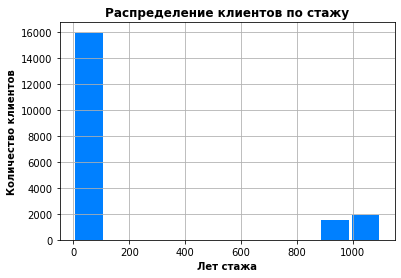

In [12]:
plot0 = data['years_employed'].hist(color='#0080ff', rwidth=0.9)
plt.xlabel('Лет стажа', weight='bold')
plt.ylabel('Количество клиентов', weight='bold')
plt.title('Распределение клиентов по стажу', weight='bold')

# строим график распределения по столбцу со стажем, чтобы посмотреть на аномальные значения
# график распределения показывает, что около 20% клиентов имеют стаж больше 50 лет

In [13]:
huge_exp = data['years_employed'] < 50 # фильтр для получения медианы без аномалий
data[huge_exp]['years_employed'].count() # 3445 значений имеют стаж выше 50 лет 
all_median_employed = data[huge_exp]['years_employed'].median() # медиана без аномалий 4 года
data.loc[data['years_employed'] > 50,'years_employed'] = all_median_employed

Text(0, 0.5, 'Кол-во клиентов')

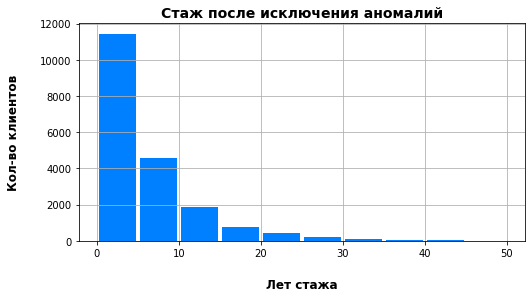

In [14]:
plot1 = data.hist(column='years_employed', bins=10, grid=True, figsize=(8,4), color='#0080ff', rwidth=0.9)
plt.title("Стаж после исключения аномалий", weight='bold', size=14)
plt.xlabel("Лет стажа", labelpad=20, weight='bold', size=12)
plt.ylabel("Кол-во клиентов", labelpad=20, weight='bold', size=12)
    
# строим тот же график, чтобы проверить все ли в порядке (спойлер: все в порядке)

In [15]:
data = data.drop(['days_employed_positive', 'days_employed','missed_income'], axis=1) 
# убираем лишние столбцы


#### Столбец с возрастом dob_years 

In [16]:
# в столбце dob_years надо исправить нулевые значения (именно 0, а не пропуски)
# для этого можно посчитать средний или медианный возраст

age_exclude0 = data['dob_years'] != 0 # фильтр для вывода медианного возраста без 0 значений
data[age_exclude0]['dob_years'].median() # так я проверил медианный возраст без 0 значений

# можно было бы обойтись и без фильтра, так как значения в целом не сильно разнятся (42 без фильтра и 43 с ним)
# или взять средний возраст, который отличается на 0,2, но я подумал, что будет корректнее учесть этот момент

data.loc[data['dob_years']== 0,'dob_years'] = 43 # заменяем все значения равные 0 на медианный возраст
# убеждаемся, что нули пропали и кол-во строк с возрастом 43 увеличилось
# data['dob_years'].value_counts()

#### Столбец с количеством детей *children*

In [17]:
display(data['children'].value_counts()) # слишком много клиентов с 20 детьми и даже клиентов с -1 ребенком
data['children'] = data['children'].abs() # убираем отрицательные значения
data.loc[data['children']== 20,'children'] = 0 # заменяем все значения c 20 детьми (всего 67) на 0
display(data['children'].value_counts())  # проверяем все ли в порядке

 0     12748
 1      4356
 2      1856
 3       294
 20       67
-1        44
 4        34
 5         8
Name: children, dtype: int64

0    12815
1     4400
2     1856
3      294
4       34
5        8
Name: children, dtype: int64

**Вывод**

Из столбцов *days_employed* и *total_income* были удалены пропущенные значения и заполнены медианными данными, так как в данном случае этот способ показался наиболее релевантным. 
В столбце с возрастом *dob_years* не было пропущенных значений, однако в нем было много значений 0, что является ошибкой (скорее всего технической при загрузке данных), которые также были заменены на средний возраст. 
В столбце с количеством детей *children* тоже не было пропущенных значений, но были некорректные. Отрицательные значения были обновлены на положительные (-1 на 1), а значения клиентов с 20 детьми были изменены на 0. Это было сложное решение, потому что я не смог выбрать 100% верный вариант в данном случае: не считать и убрать их полностью не хотелось, но считать, что у них у всех по 1 ребенку тоже не совсем корректно. Поэтому, сначала были заменены все строки с 20 детьми на 0, а затем на 1. Сравнение показало, что какой-либо значимой и ощутимой для статистики в данной таблице разницы нет.

Я понимаю, что заменять все медианными значениями это упрощение, а также потеря детализации и точности данных, но, пока я не владею техническими инструментами pandas и python на уровне, позволяющем проверять все гипотезы относительно быстро, я осознанно использовал более простой метод, чтобы не закопаться.

#### Замена типа данных

In [18]:
data['total_income'] = data['total_income'].astype(int)
data['years_employed'] = data['years_employed'].astype(int)

**Вывод**

Только в столбцах с доходом и стажем были данные типа float. На предыдущем пункте 2.1 были предварительно убраны все пропущенные значения и заменен тип данных на целочисленный методом astype.  

### Лемматизация

In [19]:
m = Mystem()

purpose_list = data['purpose'].unique()
Counter(purpose_list)

Counter({'покупка жилья': 1,
         'приобретение автомобиля': 1,
         'дополнительное образование': 1,
         'сыграть свадьбу': 1,
         'операции с жильем': 1,
         'образование': 1,
         'на проведение свадьбы': 1,
         'покупка жилья для семьи': 1,
         'покупка недвижимости': 1,
         'покупка коммерческой недвижимости': 1,
         'покупка жилой недвижимости': 1,
         'строительство собственной недвижимости': 1,
         'недвижимость': 1,
         'строительство недвижимости': 1,
         'на покупку подержанного автомобиля': 1,
         'на покупку своего автомобиля': 1,
         'операции с коммерческой недвижимостью': 1,
         'строительство жилой недвижимости': 1,
         'жилье': 1,
         'операции со своей недвижимостью': 1,
         'автомобили': 1,
         'заняться образованием': 1,
         'сделка с подержанным автомобилем': 1,
         'получение образования': 1,
         'автомобиль': 1,
         'свадьба': 1,
         'по

In [20]:
# лемматизируем слова в каждой строке для вывода основных ключевых категорий в целях кредита

def lemmatization(row):
    purpose = row['purpose']
    try:
        if 'свадь' in purpose:
            return 'свадьба'
        if 'жил' in purpose or 'недвиж' in purpose:
            return 'недвижимость'
        if 'авто' in purpose:
            return 'автомобиль'
        if 'образов' in purpose:
            return 'образование'
    except:
        print('Не удалось обработать данные')
        
data['purpose'] = data.apply(lemmatization, axis=1) # можно было бы создать отдельный столбец, но я решил использовать старый

purpose_list = data['purpose'].unique()
purpose_txt = ' '.join(purpose_list)
lemmas = m.lemmatize(purpose_txt)
Counter(lemmas)

Counter({'недвижимость': 1,
         ' ': 3,
         'автомобиль': 1,
         'образование': 1,
         'свадьба': 1,
         '\n': 1})

**Вывод**

Для того, чтобы определить основные категории в целях кредита, были лемматизированы строки в столбце *purpose* через функцию (на всякий случай была использована конструкция try-except),  лемматизированные значения записаны в тот же столбец *purpose* (можно было создать новый, но старые данные в этом столбце, на мой взгляд, не понадобятся для дальнейшего изучения, а если вдруг будут нужны, есть исходный файл). 
Далее были собраны уникальные значения в одном месте и разделены между собой пробелом. Счетчиком проверено их количество. 

Выявлено четыре категории целей кредита: **недвижимость,  автомобиль, образование, свадьба**. 


### Категоризация данных
<a id='cell3'></a>

#### По типу кредита
<a id='cell5'></a>

7.34% (718 человек) — доля должников с целью кредита "недвижимость"
9.44% (369 человек) — доля должников с целью кредита "автомобиль"
9.21% (332 человек) — доля должников с целью кредита "образование"
7.63% (161 человек) — доля должников с целью кредита "свадьба"


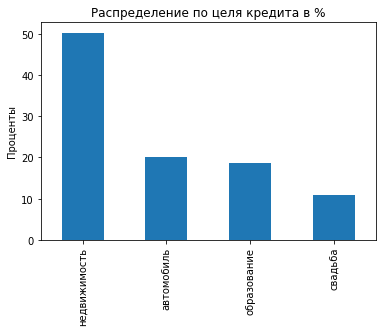

In [21]:
# используем лемматизированные данные из обновленного столбца purpose и строим базовый график для того, чтобы понять соотношение

purpose_count = data['purpose'].value_counts(normalize=True).mul(100) # соотношение целей кредита в процентах для удобства
display(purpose_count.plot.bar()) # график по целям кредита
plt.title('Распределение по целя кредита в %')
plt.ylabel('Проценты')

# cмотрим на соотношение наличия/отсутствия задолженности у клиентов с целью кредита "недвижимость"

realty = data[data.purpose == 'недвижимость']
realty_debt1 = realty[realty.debt == 1]
realty_debt1_count = realty_debt1['debt'].count()
realty_rate = realty_debt1['debt'].count() / realty['debt'].count() * 100
print(f'{realty_rate.round(2)}% ({realty_debt1_count} человек) — доля должников с целью кредита "недвижимость"')

# cмотрим на соотношение наличия/отсутствия задолженности у клиентов с целью кредита "автомобиль"

car = data[data.purpose == 'автомобиль']
car_debt1 = car[car.debt == 1]
car_debt1_count = car_debt1['debt'].count()
car_rate = car_debt1['debt'].count() / car['debt'].count() * 100
print(f'{car_rate.round(2)}% ({car_debt1_count} человек) — доля должников с целью кредита "автомобиль"')

# cмотрим на соотношение наличия/отсутствия задолженности у клиентов с целью кредита "образование"

edu = data[data.purpose == 'образование']
edu_debt1 = edu[edu.debt == 1]
edu_debt1_count = edu_debt1['debt'].count()
edu_rate = edu_debt1['debt'].count() / edu['debt'].count() * 100
print(f'{edu_rate.round(2)}% ({edu_debt1_count} человек) — доля должников с целью кредита "образование"')

# cмотрим на соотношение наличия/отсутствия задолженности у клиентов с целью кредита "свадьба"

wedding = data[data.purpose == 'свадьба']
wedding_debt1 = wedding[wedding.debt == 1]
wedding_debt1_count = wedding_debt1['debt'].count()
wedding_rate = wedding_debt1['debt'].count() / wedding['debt'].count() * 100
print(f'{wedding_rate.round(2)}% ({wedding_debt1_count} человек) — доля должников с целью кредита "свадьба"')

50% клиентов в базе планирует использовать кредит для проведения операций с недвижимостью (покупки, строительства, ремонта и др.). По 20% клиентов планирует потратить кредитные средства на приобретение автомобиля и получение образования, оставшиеся клиенты хотят получить кредит, чтобы провести свадьбу. 

Доля клиентов с задолженностью среди каждой группы *purpose* с целями кредита не превышает **7-10%**. По номинальному количеству должников лидирует группа "недвижимость" (*718*), в ней больше всего людей  и несмотря на самый низкий процент от общего числа человек в группе, номинально она самая крупная. Далее идет группа клиентов с целью кредита "автомобиль" и группа "образование" — с 369 и, соответственно, 332 клиентами в них. Меньше всего количество клиентов должников в группе "свадьба" — 161 человек. Таким образом, в абсолютных процентных значениях группы "недвижимость" и "свадьба" имеют меньшую долю клиентов с задолженностью, однако количественно группа недвижимость является самой крупной и из-за своего масштаба, 7% в ней превышает почти в два раза показатель следующей группы — 718 против 369. 

#### По наличию детей

In [22]:
def childrendebt_status(row):
    children = row['children']
    debt = row['debt']
    try:
        if children > 0 and debt == 1:
            return 'должники с детьми'
        if children == 0 and debt == 1:
            return 'должники без детей'
        return 'без долгов'
    except:
        print('Не удалось обработать данные')
    
data['childrendebt_status'] = data.apply(childrendebt_status, axis=1)

Text(0, 0.5, 'Количество клиентов')

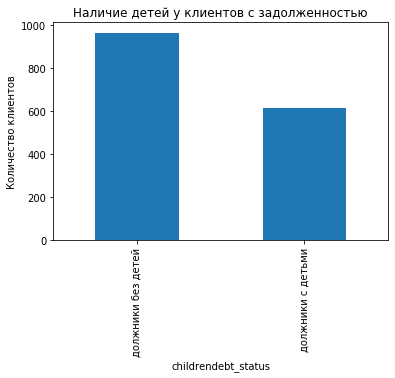

In [23]:
# строим простой график, чтобы понять соотношение задолженностей у разных категорий (кроме тех, у кого нет долга, конечно)

childrendebt_data = data[data.childrendebt_status != 'без долгов'] # исключаем тех, у кого нет долга, чтобы они не портили картину
childrendebt_plot = childrendebt_data.groupby('childrendebt_status').size() # группируем данные, чтобы посмотреть на соотношение
display(childrendebt_plot.plot.bar()) # график для вывода соотношения клиентов с задолженностью с детьми и без
plt.title('Наличие детей у клиентов с задолженностью')
plt.ylabel('Количество клиентов')

In [24]:
# смотрим на соотношение наличия/отсутствия задолженности у клиентов с детьми
havechildren = data[data.children != 0]
havechildren_debt1 = havechildren[havechildren.debt == 1]
havechildren_debt1_count = havechildren_debt1['debt'].count()
havechildren_rate = havechildren_debt1['debt'].count() / havechildren['debt'].count() * 100
print(f'{havechildren_rate.round(2)}% ({havechildren_debt1_count} человек) — доля должников с детьми')

# смотрим на соотношение наличия/отсутствия задолженности у клиентов без детей

nochildren = data[data.children == 0]
nochildren_debt1 = nochildren[nochildren.debt == 1]
nochildren_debt1_count = nochildren_debt1['debt'].count()
nochildren_rate = nochildren_debt1['debt'].count() / nochildren['debt'].count() * 100
print(f'{nochildren_rate.round(2)}% ({nochildren_debt1_count} человек) — доля должников без детей')

9.31% (614 человек) — доля должников с детьми
7.54% (966 человек) — доля должников без детей


Для сравнения надежности заемщиков был создан столбец *childrendebt_status* с тремя возможными значениями: 
- клиенты с детьми имеющие задолженность
- клиенты без детей имеющие задолженность
- клиенты без задолженности

По графику *childrendebt_plot* видно, что ~60% всех клиентов, имевших задолженность не имеют детей. Но среди клиентов с детьми или без детей доля клиентов с задолженностью не превышает уже упомянутые выше 7-10%. 

В процентном соотношении доля должников в группе клиентов с детьми ниже, однако из-за большего количества человек в этой группе, количественно должников здесь больше где-то на 30%: **966 против 614 клиентов.**

#### По семейному статусу

In [25]:
def familydebt_status(row):
    family = row['family_status_id']
    debt = row['debt']
    try:
        if family == 0 and debt == 1:
            return 'должники в браке'
        if family == 1 and debt == 1:
            return 'должники в гражданском браке'
        if family == 2 and debt == 1:
            return 'должники вдовцы'
        if family == 3 and debt == 1:
            return 'должники в разводе'
        if family == 4 and debt == 1:
            return 'должники холостые'
        return 'люди без долгов'
    except:
        print('Не удалось обработать данные')

data['familydebt_status'] = data.apply(familydebt_status, axis=1)

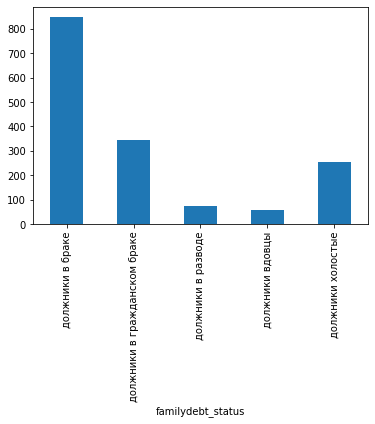

In [26]:
# строим график, чтобы понять соотношение задолженностей у разных категорий (кроме тех, у кого нет долга, конечно)

familydebt_data = data[data.familydebt_status != 'люди без долгов'] # исключаем тех, у кого нет долга, чтобы они не портили картину
familydebt_plot = familydebt_data.groupby('familydebt_status').size() 
familydebt_plot.plot.bar()

In [27]:
# смотрим на соотношение наличия/отсутствия задолженности у клиентов в браке (оф и гр)
marriage = data[(data.family_status_id == 0) | (data.family_status_id == 1)]
marriage_debt1 = marriage[marriage.debt == 1]
marriage_debt1_count = marriage_debt1['debt'].count()
marriage_rate = marriage_debt1['debt'].count() / marriage['debt'].count() * 100
print(f'{marriage_rate.round(2)}% ({marriage_debt1_count} человек) — доля должников с браке (оф/гражд)')

# смотрим на соотношение наличия/отсутствия задолженности у клиентов не в браке
nomarriage = data[(data.family_status_id == 2) | (data.family_status_id == 3) | (data.family_status_id == 3) | (data.family_status_id == 4)]
nomarriage_debt1 = nomarriage[nomarriage.debt == 1]
nomarriage_debt1_count = nomarriage_debt1['debt'].count()
nomarriage_rate = nomarriage_debt1['debt'].count() / nomarriage['debt'].count() * 100
print(f'{nomarriage_rate.round(2)}% ({nomarriage_debt1_count} человек) — доля должников не в браке')

7.99% (1192 человек) — доля должников с браке (оф/гражд)
8.65% (388 человек) — доля должников не в браке


Для сравнения надежности заемщиков был создан столбец *familydebt_status* с шестью возможными значениями для каждого типа семейного статуса:
- женат/замужем
- гражданский брак
- вдовец/вдова
- в разводе
- не женат/не замужем
- клиенты без задолженности

Доля клиентов с задолженностью в каждой из категорий не превышает **10%** (колеблется между 7-10%). По графику *familydebt_plot* видно, что большинство клиентов, имевших задолженность, находятся в зарегистрированном или гражданском браке. При этом всего клиентов в браке и гражд.браке от общего кол-ва клиентов  базе аналогично ~ 75%.

В связи с тем, что в числовом выражении преобладающее большинство клиентов в браке (около 15 тысяч клиентов против 4 тысяч не в браке), несмотря на почти одинаковые доли, количество должников в браке в три раза больше: 1192 против 388.

P.S. 
Были проверены все категории, однако в связи с отсутствием существенных различий в долях они были объединены в коде в две группы (клиенты в браке и не в браке).   

#### По уровню дохода

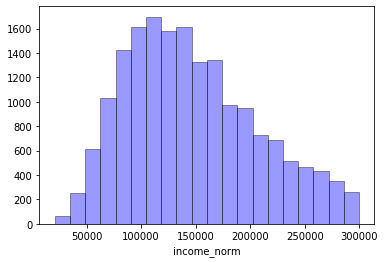

In [28]:
# видим, что большая часть клиентов имеет доход не более 300к в месяц, а менее 1500 клиентов имеют доходы выше

# строим гистограмму без выделяющихся значений
data['income_norm'] = data['total_income'][data.total_income <= 300000] # создаем столбец, в котором нет выделяющихся значений 
sns.distplot(data['income_norm'], hist=True, kde=False, bins=20, color = 'blue', hist_kws={'edgecolor':'black'})

# столбец income_norm можно удалить, но тогда график выше поломается, поэтому я его оставил, но он в целом не нужен

In [29]:
# используем qcut для распределения клиентов по квантилям на равные группы по доходу
data['total_income_status'] = pd.qcut(data.total_income,q=5,
labels=['низкий доход', 'средний доход', 'доход выше среднего', 'высокий доход', 'очень высокий доход'])

In [30]:
low_income = data[data.total_income_status == 'низкий доход'] # смотрим на группу клиентов с низким доходом
low_income_debt1 = low_income[low_income.debt == 1]
low_income_debt1_count = low_income_debt1['debt'].count()
low_income_rate = low_income_debt1['debt'].count() / low_income['debt'].count() * 100
print(f'{low_income_rate.round(2)}% ({low_income_debt1_count} человек) — доля должников с низким доходом')

mid_income = data[data.total_income_status == 'средний доход'] # смотрим на группу клиентов со средним доходом
mid_income_debt1 = mid_income[mid_income.debt == 1]
mid_income_debt1_count = mid_income_debt1['debt'].count()
mid_income_rate = mid_income_debt1['debt'].count() / mid_income['debt'].count() * 100
print(f'{mid_income_rate.round(2)}% ({mid_income_debt1_count} человек) — доля должников со средним доходом')

midplus_income = data[data.total_income_status == 'доход выше среднего'] # смотрим на группу клиентов с доходом выше среднего
midplus_income_debt1 = midplus_income[midplus_income.debt == 1]
midplus_income_debt1_count = midplus_income_debt1['debt'].count()
midplus_income_rate = midplus_income_debt1['debt'].count() / midplus_income['debt'].count() * 100
print(f'{midplus_income_rate.round(2)}% ({midplus_income_debt1_count} человек) — доля должников с доходом выше среднего')

hign_income = data[data.total_income_status == 'высокий доход'] # смотрим на группу клиентов с высоким доходом
hign_income_debt1 = hign_income[hign_income.debt == 1]
hign_income_debt1_count = hign_income_debt1['debt'].count()
hign_income_rate = hign_income_debt1['debt'].count() / hign_income['debt'].count() * 100
print(f'{hign_income_rate.round(2)}% ({hign_income_debt1_count} человек) — доля должников с высоким доходом')

veryhign_income = data[data.total_income_status == 'очень высокий доход'] # смотрим на группу клиентов с высоким доходом
veryhign_income_debt1 = veryhign_income[veryhign_income.debt ==1]
veryhign_income_debt1_count = veryhign_income_debt1['debt'].count()
veryhign_income_rate = veryhign_income_debt1['debt'].count() / veryhign_income['debt'].count() * 100
print(f'{veryhign_income_rate.round(2)}% ({veryhign_income_debt1_count} человек) — доля должников с очень высоким доходом')

8.04% (312 человек) — доля должников с низким доходом
8.4% (326 человек) — доля должников со средним доходом
8.71% (338 человек) — доля должников с доходом выше среднего
8.5% (330 человек) — доля должников с высоким доходом
7.06% (274 человек) — доля должников с очень высоким доходом


In [31]:
display(low_income['total_income'].median())
display(mid_income['total_income'].median())
display(midplus_income['total_income'].median())
display(hign_income['total_income'].median())
display(veryhign_income['total_income'].median())

76129.0

111334.0

144732.0

188918.0

277946.0

На графике распределения доходов без клиентов с доходами свыше 300 тыс. рублей, видно, что выделяется значение 145 тысяч рублей, потому что мы заполнили их медианной зарплатой в пункте 2.1.3. 

Большая часть клиентов (~75%) имеет доход свыше 50 и ниже 200 тысяч рублей, ~21% клиентов с средними доходами, 2% c очень высокими доходами, и чуть менее 2% клиентов с низкими доходами менее 50 тысяч рублей. 

Для разделения групп был использован метод qcut для рравномерного распределения клиентов по квантилям. Было выведено пять групп клиентов:
- с низкими доходами (медианный доход 76 тысяч)
- со средними доходами (медианный доход 111 тысяч)
- с доходами выше среднего (медианный доход 144 тысяч)
- с высокими доходами (медианный доход 189 тысяч)
- с очень высокими доходами (медианный доход 278 тысяч)

Количество и доли должников практически не отличаются, выделяется только группа клиентов с очень высокими доходами — среди них меньше всего должников.

**Вывод**

Для анализа и сопоставления клиенты были категоризированы по следующим характеристикам:

    1. Целям кредита
    2. Наличию детей
    3. Семейному статусу
    4. Уровню дохода
    
В рамках каждой из категорий клиенты были распределены в различные группы, однако ни одна из них не имеет долю клиентов с задолженностью свыше 10%.

Портрет среднего клиента с задолженностью исходя из имеющихся данных:

    1. 39-40 лет (с большей вероятностью женщина)
    2. Скорее всего без детей
    3. Со стажем работы 5 лет
    4. Скорее всего со средним образованием
    5. Cкорее всего замужем/в гражданском браке
    6. Цель кредита - операции с недвижимостью
    7. C ежемесячным доходом 140-160 тысяч рублей

In [32]:
data.pivot_table(index=['purpose'], values=['children', 'total_income', 'dob_years'], 
columns='debt', aggfunc={'debt': 'count', 'total_income': ['median','max'], 'dob_years':'mean'})

# cводная таблица, которая позволяет выделить усредненный портрет клиента с задолженностью по категории "цель кредита"

debt       dob_years            total_income             \
             count            mean                     max              
debt             0    1          0          1            0          1   
purpose                                                                 
автомобиль    3541  369  44.064389  40.409214    1427934.0   618523.0   
недвижимость  9063  718  43.573982  40.282730    2265604.0  2200852.0   
образование   3273  332  43.892148  40.542169    1726276.0  1030899.0   
свадьба       1950  161  43.544615  41.689441    1711309.0   535227.0   

                                  
                median            
debt                 0         1  
purpose                           
автомобиль    143809.0  143991.0  
недвижимость  146293.0  146969.5  
образование   143425.0  139113.5  
свадьба       144660.0  128241.0

In [33]:
data.pivot_table(index=['education'], values=['children', 'total_income', 'dob_years'], 
columns='debt', aggfunc={'debt': 'count', 'total_income': ['median','max'], 'dob_years':'mean'}, fill_value=0)

# cводная таблица которая позволяет выделить усредненный портрет клиента с задолженностью по категории "образование"

debt        dob_years            total_income           \
                     count             mean                     max            
debt                     0     1          0          1            0        1   
education                                                                      
высшее                4475   253  40.997989  39.557312      2265604  2200852   
начальное              234    28  48.581197  39.321429       490067   284302   
неоконченное высшее    611    65  34.417349  34.753846       958435   822426   
среднее              12501  1234  45.063915  41.035656      1726276  1030899   
ученая степень           6     0  51.166667   0.000000       268411        0   

                                       
                     median            
debt                      0         1  
education                              
высшее               175542  168110.0  
начальное            115301  124058.5  
неоконченное высшее  158444  185274.0  
среднее              136030  137354.5  
ученая степень       157260       0.0

<a id='cell6'></a>

In [34]:
children_dict = {
    'бездетная семья': 0, 
    'малодетная семья': 1,
    'многодетная семья': 2
}
children_dict

{'бездетная семья': 0, 'малодетная семья': 1, 'многодетная семья': 2}

In [56]:
# рассчет долей по всем вариантам в рамках параметра "количество детей" 
data.pivot_table(index=['education'], columns='children', values='debt', fill_value=0, margins=True)

children,0,1,2,3,4,5,All
education,,,,,,,
высшее,0.053238,0.055184,0.053785,0.040541,0.000000,0,0.053511
начальное,0.074713,0.175439,0.208333,0.000000,0.000000,0,0.106870
неоконченное высшее,0.076577,0.125000,0.136364,0.333333,0.000000,0,0.096154
среднее,0.082432,0.105827,0.107595,0.082126,0.111111,0,0.089843
ученая степень,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
All,0.075380,0.093636,0.095366,0.074830,0.088235,0,0.081414


## Ответы на ключевые вопросы
<a id='cell4'></a>

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Благодаря категоризации по наличию детей, можно убедиться, что всего клиентов c детьми от общего количества клиентов — порядка 67%. Среди клиентов, имеющих задолженность соотношение сохраняется. 

Сравнив *две категории клиентов с задолженностью*: клиентов без детей и клиентов с детьми можно увидеть, что бОльшая часть клиентов с задолженностью не имеет детей (соотношение приблизительно 65% на 35%). Это видно на графике *childrendebt_plot* ниже.

Далее, сравнив соотношение клиентов с задолженностью и без нее для каждой из двух групп: *всех клиентов без детей* и *всех клиентов с детьми*, мы можем сделать вывод, что наличие или отсутствие детей, в целом, не оказывает существенного влияния на возврат кредита в срок. В процентном соотношении доля клиентов с задолженностью в обоих группах остается в пределах 7-10%. Это видно на графиках *Задолженность у клиентов с детьми* и *Задолженность у клиентов без детей*.

- 9.31% (614 человек) — доля должников с детьми
- 7.54% (966 человек) — доля должников без детей

В процентном соотношении доля должников в группе клиентов с детьми ниже, однако из-за большего количества человек в этой группе (13 тысяч против 6 тысяч), количественно должников здесь больше где-то на 30%: **966 против 614 клиентов.** Соотношение должников же группы без детей к общей доле (всей базе) одно из самых высоких как в процентном отношении (5%), так и в количественном (966).

- 3.2% — доля должников с детьми от всей базы
- 5.0% — доля должников без детей от всей базы

Тем не менее, исходя из имеющихся данных, мы можем сделать вывод, что наличие детей не оказывает значительного влияния на возврат кредита в срок. Клиентов без детей в базе больше, однако, несмотря на то, что у них выше и доля должников, эта разница не очень велика. 

Text(0, 0.5, 'Количество клиентов')

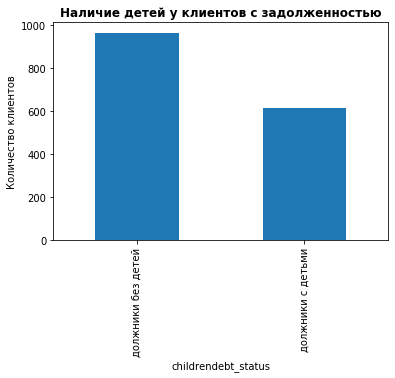

In [35]:
childrendebt_plot.plot.bar()
plt.title('Наличие детей у клиентов с задолженностью', weight='bold')
plt.ylabel('Количество клиентов')

Text(0, 0.5, 'Количество клиентов')

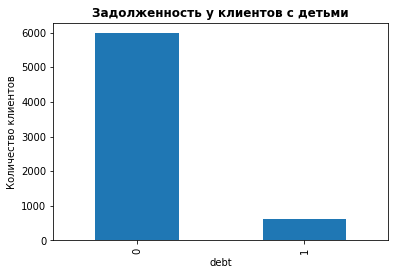

In [36]:
havechildren_plot = havechildren.groupby('debt').size()
havechildren_plot.plot.bar()
plt.title('Задолженность у клиентов с детьми', weight='bold')
plt.ylabel('Количество клиентов')

Text(0, 0.5, 'Количество клиентов')

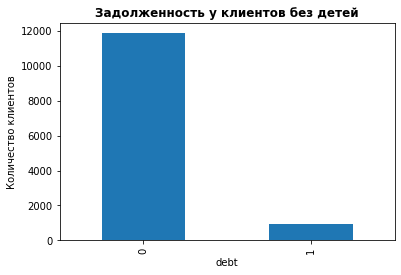

In [37]:
nochildren_plot = nochildren.groupby('debt').size()
nochildren_plot.plot.bar()
plt.title('Задолженность у клиентов без детей', weight='bold')
plt.ylabel('Количество клиентов')

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Категоризировав клиентов по семейному статусу и наличию задолженностей у них, были получены шесть групп: пять групп клиентов с задолженностями аналогично семейным статусам исходной таблицы и шестая группа клиентов без задолженностей.

График *familydebt_plot* ниже демонстрирует, что порядка **75%** всех клиентов, имевших задолженность, находятся в **зарегистрированном или гражданском браке**. Однако такое соотношение сохраняется и среди клиентов без задолженности, а также при анализе всей базы в целом — доля клиентов в официальном и гражданском браке от общего количества также около 75%.

Если изучить каждую из выделенных в данной категории групп на соотношение клиентов с задолженностью к общему числу в группе (больше деталей в пункте 2.4.3), то мы снова увидим цифры около **7-10%**.

Поэтому высокий процент клиентов в браке среди клиентов с задолженностью не может подтвердить наличие влияния брака на возврат кредита в срок, так как такое соотношение сохраняется и в целом для всей базы, и сугубо для клиентов без задолженностей. 

- 6.1% (1192 человек) — доля должников в браке от всей базы
- 2.0% (388 человек) — доля должников не в браке от всей базы

В процентном соотношении от общей доли всех участников таблицы, можно заметить существенное отличие доли должников в браке (учитывались и официальные браки, и гражданские). Таким образом, группа клиентов, состоящих в браке занимает первое место по количеству должников, как по доле (6.1%), так и непосредственно по количеству (1192 человека) среди всех групп всех категорий.

Однако это самая многочисленная группа из рассматриваемых, а доля в 8% внутри группы и 6% в целом по базе, конечно, велика, но не настолько, чтобы можно было заявлять о сильной взаимосвязи. **При этом, не учитывать этот аспект тоже некорректно: очевидно, что вероятность того, что клиент не вернет долг, гораздо выше в группе "в браке"**.

Text(0, 0.5, 'Количество клиентов')

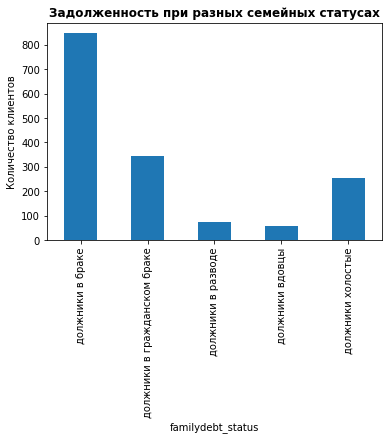

In [38]:
familydebt_plot.plot.bar()
plt.title('Задолженность при разных семейных статусах', weight='bold')
plt.ylabel('Количество клиентов')

***

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

При анализе по этой категории, клиенты были поделены на равномерные группы квантилями по уровню дохода:   

- 8.04% (312 человек) — доля должников с низким доходом (медианный доход 76 тысяч)
- 8.4% (326 человек) — доля должников со средним доходом (медианный доход 76 тысяч)
- 8.71% (338 человек) — доля должников с доходом выше среднего (медианный доход 111 тысяч)
- 8.5% (330 человек) — доля должников с высоким доходом (медианный доход 144 тысяч)
- 7.06% (274 человек) — доля должников с очень высоким доходом (медианный доход 278 тысяч)

Среди клиентов по каждой группе дохода (низкий, средний, выше среднего, высокий и очень высокий), **доля клиентов с задолженностью всегда составляет около 8%**, аналогично предыдущим категориям. Заметна небольшая разница у клиентов в группе с самым высоким доходом: в ней меньше всего должников. Впрочем, группа с низким доходом идет на втором месте по количеству, поэтому утверждать, что клиенты с определенным уровнем дохода не возвращают кредиты в срок значительно чаще других клиентов, сложно. 

В отличие от других категорий, при категоризации по доходу группы были распределены равномерно по квантилям, пооэтому  процентные и количественные значения между группами совпадают и в данной категории нет группы, в которой было бы больше должников из-за разницы в исходном количестве человек. Общее соотношение должников разных групп доходов к базе также в целом среднее и не выделяется ни в какую сторону от общей тенденции по всей базе.

- 1.61% — доля должников с низким доходом от всей базы
- 1.68% — доля должников со средним доходом от всей базы
- 1.7% — доля должников с доходом выше среднего от всей базы
- 1.7% — доля должников с высоким доходом от всей базы
- 1.4% — доля должников с очень высоким доходом от всей базы

***
- Как разные цели кредита влияют на его возврат в срок?

Из запросов всех клиентов в ходе лемматизации было выявдено четыре группы в категории "цель кредита": недвижимость, образование, автомобиль и свадьба.  

Половина всех клиентов в базе планирует использовать кредит для проведения операций с недвижимостью (покупки, строительства, ремонта и др.). Приблизительно по 20% клиентов собирается потратить кредитные средства на покупку автомобиля и получение образования. При этом, оставшиеся клиенты (около 10%), нуждаются в кредите для проведения свадьбы. 

Доля клиентов с задолженностью среди каждой группы с целями кредита не превышает **7-10%**. Это можно увидеть на графиках в пункте [2.4.1](#cell5)

- 7.34% (718 человек) — доля должников с целью кредита "недвижимость" 

- 9.44% (369 человек) — доля должников с целью кредита "автомобиль"

- 9.21% (332 человек) — доля должников с целью кредита "образование"

- 7.63% (161 человек) — доля должников с целью кредита "свадьба"

При этом в процентном соотношении от всей базы группы между собой различаются достаточно сильно, в связи с тем, что они разные по количеству человек.

3.7% — доля должников с целью кредита "недвижимость" от всей базы
1.9% — доля должников с целью кредита "автомобиль" от всей базы
1.7% — доля должников с целью кредита "образование" от всей базы
0.8% — доля должников с целью кредита "свадьба" от всей базы

В рамках каждой из категории нет выходов за пределы 10% доли клиентов с задолженностью, однако из-за разных масштабов групп, самая большая по количеству клиентов группа ("недвижимость") имеет самое большое количество должников (718 человек) и достаточно высокую долю от всей базы (3.7%), несмотря на самый низкий процент должников от доли в группе. Соответственно, **цели кредита не влияют на вероятность возврата кредита в срок клиентами этой группы**, но клиенты группы "недвижимость" одни из наиболее вероятных клиентов, которые могут получить задолженность.

In [39]:
# Считаем долю должников от всей базы (а не внутри группы)

realty_rate = realty_debt1['debt'].count() / data['debt'].count() * 100
print(f'{realty_rate.round(2)}% ({realty_debt1_count} человек) — доля должников с целью кредита "недвижимость" от всей базы')

car_rate = car_debt1['debt'].count() / data['debt'].count() * 100
print(f'{car_rate.round(2)}% ({car_debt1_count} человек) — доля должников с целью кредита "автомобиль" от всей базы')

edu_rate = edu_debt1['debt'].count() / data['debt'].count() * 100
print(f'{edu_rate.round(1)}% ({edu_debt1_count} человек) — доля должников с целью кредита "образование" от всей базы')

wedding_rate = wedding_debt1['debt'].count() / data['debt'].count() * 100
print(f'{wedding_rate.round(1)}% ({edu_debt1_count} человек) — доля должников с целью кредита "свадьба" от всей базы')

havechildren_rate = havechildren_debt1['debt'].count() / data['debt'].count() * 100
print(f'{havechildren_rate.round(1)}% ({havechildren_debt1_count} человек) — доля должников с детьми от всей базы')

nochildren_rate = nochildren_debt1['debt'].count() / data['debt'].count() * 100
print(f'{nochildren_rate.round(1)}% ({nochildren_debt1_count} человек) — доля должников без детей от всей базы')

marriage_rate = marriage_debt1['debt'].count() / data['debt'].count() * 100
print(f'{marriage_rate.round(1)}% ({marriage_debt1_count} человек) — доля должников в браке от всей базы')

nomarriage_rate = nomarriage_debt1['debt'].count() / data['debt'].count() * 100
print(f'{nomarriage_rate.round(1)}% ({nomarriage_debt1_count} человек) — доля должников не в браке от всей базы')

low_income_rate = low_income_debt1['debt'].count() / data['debt'].count() * 100
print(f'{low_income_rate.round(2)}% ({low_income_debt1_count} человек) — доля должников с низким доходом от всей базы')

mid_income_rate = mid_income_debt1['debt'].count() / data['debt'].count() * 100
print(f'{mid_income_rate.round(2)}% ({mid_income_debt1_count} человек) — доля должников со средним доходом от всей базы')

midplus_income_rate = midplus_income_debt1['debt'].count() / data['debt'].count() * 100
print(f'{midplus_income_rate.round(1)}% ({midplus_income_debt1_count} человек) — доля должников с доходом выше среднего от всей базы')

hign_income_rate = hign_income_debt1['debt'].count() / data['debt'].count() * 100
print(f'{hign_income_rate.round(1)}% ({hign_income_debt1_count} человек) — доля должников с высоким доходом от всей базы')

veryhign_income_rate = veryhign_income_debt1['debt'].count() / data['debt'].count() * 100
print(f'{veryhign_income_rate.round(1)}% ({veryhign_income_debt1_count} человек) — доля должников с очень высоким доходом от всей базы')

3.7% (718 человек) — доля должников с целью кредита "недвижимость" от всей базы
1.9% (369 человек) — доля должников с целью кредита "автомобиль" от всей базы
1.7% (332 человек) — доля должников с целью кредита "образование" от всей базы
0.8% (332 человек) — доля должников с целью кредита "свадьба" от всей базы
3.2% (614 человек) — доля должников с детьми от всей базы
5.0% (966 человек) — доля должников без детей от всей базы
6.1% (1192 человек) — доля должников в браке от всей базы
2.0% (388 человек) — доля должников не в браке от всей базы
1.61% (312 человек) — доля должников с низким доходом от всей базы
1.68% (326 человек) — доля должников со средним доходом от всей базы
1.7% (338 человек) — доля должников с доходом выше среднего от всей базы
1.7% (330 человек) — доля должников с высоким доходом от всей базы
1.4% (274 человек) — доля должников с очень высоким доходом от всей базы


In [40]:
# создаем датафрейм с долями и всеми группами

total = pd.DataFrame({'name':['Должники с целью кредита "недвижимость"', 'Должники с целью кредита "автомобиль"', 'Должники с целью кредита "образование"', 'Должники с целью кредита "свадьба"', 'Должники с детьми', 'Должники без детей', 'Должники в браке',
'Должники не в браке', 'Должники с низким доходом', 'Должники со средним доходом','Должники с доходом выше среднего', 'Должники с высоким доходом', 'Должники с очень высоким доходом'], 'доля': [3.7, 1.9, 1.7, 0.8, 3.2, 5.0, 6.1, 2.0, 1.6, 1.7, 1.7, 1.7, 1.4], 'человек в доле': [718, 369, 332, 332, 614, 966, 1192, 388, 312, 326, 338, 330, 274]})

In [41]:
# сортируем таблицу по кол-ву людей (можно и по доле для интереса)
total.sort_values('человек в доле', ascending=False)

,name,доля,человек в доле
6,Должники в браке,6.1,1192
5,Должники без детей,5.0,966
0,"Должники с целью кредита ""недвижимость""",3.7,718
4,Должники с детьми,3.2,614
7,Должники не в браке,2.0,388
1,"Должники с целью кредита ""автомобиль""",1.9,369
10,Должники с доходом выше среднего,1.7,338
2,"Должники с целью кредита ""образование""",1.7,332
3,"Должники с целью кредита ""свадьба""",0.8,332
11,Должники с высоким доходом,1.7,330


## Общий вывод

В таблице с данными было обнаружено несколько столбцов с аномальными значениями. Наилучшим способом решения этой проблемы была бы возможность связаться с источником данных и попробовать уточнить их или хотя бы выяснить причины появления ошибок, однако в связи с невозможностью это сделать, можно выдвинуть некоторые гипотезы. 

Так, возможными причинами появления аномальных значений могут быть как технические проблемы и ошибки (неверный автовыбор формата для данных в условном Excel или некорректная загрузка из источника), так и человеческий фактор, сказавшийся при сборе данных или загрузке (сбор из разных источников без обязательного единого вида, ошибка при вводе или сохранении). 

Все клиенты были разделены на категории и подкатегории по разным характеристикам: от семейного статуса и наличия детей до уровня доходов и целей запрашиваемого кредита.

Несмотря на то, что среди небольшой группы клиентов с задолженностями можно нарисовать усредненный портрет такого клиента (женщина около 40 лет со средним образованием, без детей и в официальном или гражданском браке, с целью кредита, связанной с недвижимостью), сказать про то, что какая-то из категорий имеет существенно больше "должников" нельзя. 

Среди всех клиентов, задолженность имеет всего **1580**, т.е около 8% от общего числа в базе. В целом, среди всех категорий этот уровень сохраняется: доля "должников" около **7-10%** для каждой группы клиентов. 

Конечно, можно говорить, что в категориях с долей должников около 10% существует бОльшая вероятность невозврата долга и в целом это имеет место, однако, учитывая не 100% точность данных и относительно невысокий уровень расхождения в 1,5-2% максимум, такая трактовка, вероятно, все же не совсем корректна и скорее похожа на подгон результатов под гипотезу, чем на выводы по итогам исследования. 

Однако, в связи с разным количеством человек в каждой группе, реальные количественные данные в самых крупных группах существенно выше. Это наблюдается в категориях:

- По цели кредита (группа "недвижимость") — около 10 тысяч человек, 700 должников, доля должников в группе 7%
- По наличию детей (группа "без детей") — около 12 тысяч человек, чуть менее 1000 должников, доля должников в группе 7%
- По семейному статусу (группа "в браке") — около 15 тысяч человек, почти 1200 должников, доля должников в группе 8%

Если считать в долях от общего количества людей (то есть от всей базы), то в среднем доля должников по всем группам **2.5%**.
Самые крупные по количеству людей группы: клиенты в браке и клиенты без детей на первых местах по доле в процентном соотношении и количеству должников: 

1. Должники в браке, **6.1% доля**, кол-во человек в доле **1192**
2. Должники без детей, **5% доля**, кол-во человек в доле **966**

Лучше всего с долгами ситуация в процентном соотношении у клиентов, стремящихся получить кредит на проведение свадьбы — 0,8%, а по количеству человек группа клиентов с очень высоким доходом — 274 человека.  

После анализа всех категорий клиентов, можно сделать вывод, что влияние разных характеристик клиентов на вероятность возврата кредита в срок, в целом, равное, так как **никакие группы клиентов ни по одной из рассмотренных категорий, не имеют значительного превышения доли клиентов с задолженностью**, однако некоторые группы имеют незначительно большую вероятность не вернуть долг.